# London Crime Rate Analysis

## Introduction

Pada kesempatan kali ini, saya akan melakukan analisis data pada dataset London Crime Data, 2008-2016. Data ini saya peroleh pada kaggle pada link ini [London Crime Data](https://www.kaggle.com/datasets/jboysen/london-crime).

Untuk detail masing-masing kolom pada data ini sebagai berikut :
- lsoa_code: code for Lower Super Output Area in Greater London.
- borough: Common name for London borough.
- major_category: High level categorization of crime
- minor_category: Low level categorization of crime within major category.
- value: monthly reported count of categorical crime in given borough
- year: Year of reported counts, 2008-2016
- month: Month of reported counts, 1-12


## Data Preparation

### Load the required package

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import folium

### Load the dataset

In [3]:
crime = pd.read_csv('london_crime_by_lsoa.csv')
crime.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


In [4]:
crime.tail()

,lsoa_code,borough,major_category,minor_category,value,year,month
13490599,E01000504,Brent,Criminal Damage,Criminal Damage To Dwelling,0,2015,2
13490600,E01002504,Hillingdon,Robbery,Personal Property,1,2015,6
13490601,E01004165,Sutton,Burglary,Burglary in a Dwelling,0,2011,2
13490602,E01001134,Croydon,Robbery,Business Property,0,2011,5
13490603,E01003413,Merton,Violence Against the Person,Wounding/GBH,0,2015,6


Ternyata dataset tidak memiliki missing values, maka tahapan analisis dapat dilanjutkan

### Data wrangling

Sebelum melakukan analisis lebih lanjut, kita akan melihat struktur data terlebih dahulu untuk memahami data lebih baik

In [5]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13490604 entries, 0 to 13490603
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   lsoa_code       object
 1   borough         object
 2   major_category  object
 3   minor_category  object
 4   value           int64 
 5   year            int64 
 6   month           int64 
dtypes: int64(3), object(4)
memory usage: 720.5+ MB


Dari struktur data diatas, kita dapat melihat bahwa ada kolom yang harus kita ubah terlebih dahulu yakni major_category, minor_category ubah kedalam bentuk category.  

In [6]:
crime[['major_category', 'minor_category']] = crime[['major_category', 'minor_category']].astype('category')

In [7]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13490604 entries, 0 to 13490603
Data columns (total 7 columns):
 #   Column          Dtype   
---  ------          -----   
 0   lsoa_code       object  
 1   borough         object  
 2   major_category  category
 3   minor_category  category
 4   value           int64   
 5   year            int64   
 6   month           int64   
dtypes: category(2), int64(3), object(2)
memory usage: 540.4+ MB


Dan dari informasi dataset kita akan membuang kolom **Isoa_code** karena kolom ini tidak akan proses untuk analisis

In [8]:
crime_clean = crime.iloc[:,1:]

### Checking for missing values

Selanjutnya akan kita cek, apakah dataset memiliki **missing values** atau tidak

In [9]:
crime_clean.isna().sum()

borough           0
major_category    0
minor_category    0
value             0
year              0
month             0
dtype: int64

Ternyata dataset tidak memiliki missing values, maka tahapan analisis dapat dilanjutkan

## Analysis

### Bagaimana distribusi tingkat kejahatan yang dilaporkan perbulannya?

Untuk menjawab pertanyaan ini, maka kita akan memvisualisasikan kolom value menggunakan histogram

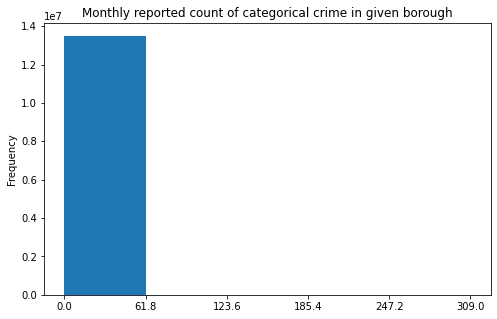

In [10]:
count, bin_edges = np.histogram(crime.value, bins=5)
crime_clean['value'].T.plot(kind='hist',
             bins=5,
             xticks=bin_edges,
             figsize=(8,5));
plt.title("Monthly reported count of categorical crime in given borough");

Berdasarkan histogram diatas, jumlah laporan kejahatan perbulannya berdistribusi pada titik 0 - 62 laporan. 

### Pada minor category manakah 10 kategori kejahatan yang paling besar?

In [11]:
minor_crime = crime_clean[['minor_category', 'value']].groupby('minor_category').sum().sort_values(by='value', ascending=False).head(10)

In [12]:
minor_crime

,value
minor_category,
Other Theft,980085
Theft From Motor Vehicle,569956
Burglary in a Dwelling,491282
Harassment,458124
Assault with Injury,451001
Possession Of Drugs,431948
Common Assault,413690
Theft From Shops,345142
Other Theft Person,308842


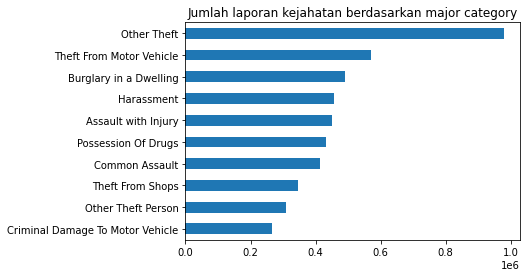

In [13]:
minor_crime.sort_values(by='value', ascending=True).plot(kind='barh')
plt.xlabel('')
plt.ylabel("")
plt.legend().remove()
plt.title('Jumlah laporan kejahatan berdasarkan major category')
plt.show()

Dari data dan visualisasi diatas didapatkan bahwa jumlah 3 laporan kejahatan terbanyak terdapat pada kategori **Other Theft**, **Theft From Motor Vehicle** dan **Burglary in a Dwelling**, dan diikuti oleh kategori-kategori lainnya

### Apakah setiap setiap bertambah bulan meningkatkan nilai value?

Untuk menjawab pertanyaan ini, kita kan melihat korelasi antara 2 kolom ini

In [14]:
np.corrcoef(crime_clean.month, crime_clean.value)

array([[1.        , 0.00182118],
       [0.00182118, 1.        ]])

variabel month dengan value hampir tidak mempunyai korelasi atau mendekati 0, berikut merupakan visualisasi dari data diatas

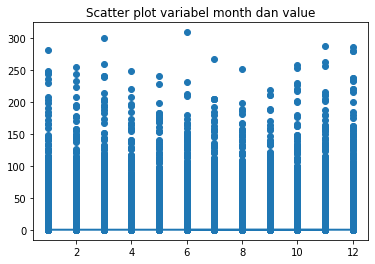

In [15]:
x = crime_clean.month
y = crime_clean.value
slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)

plt.title("Scatter plot variabel month dan value")
plt.show()

Kesimpulan yang dapat diambil adalah bulan tidak mempengaruhi nilai value

### Pada major category berapa total proporsi laporan kejahatan yang terjadi pada masing-masing kategori?

In [16]:
crime_major = crime_clean[['major_category', 'value']].groupby('major_category').sum().sort_values(by='value', ascending=False)

In [17]:
crime_major

,value
major_category,
Theft and Handling,2661861
Violence Against the Person,1558081
Burglary,754293
Criminal Damage,630938
Drugs,470765
Robbery,258873
Other Notifiable Offences,106349
Fraud or Forgery,5325
Sexual Offences,1273


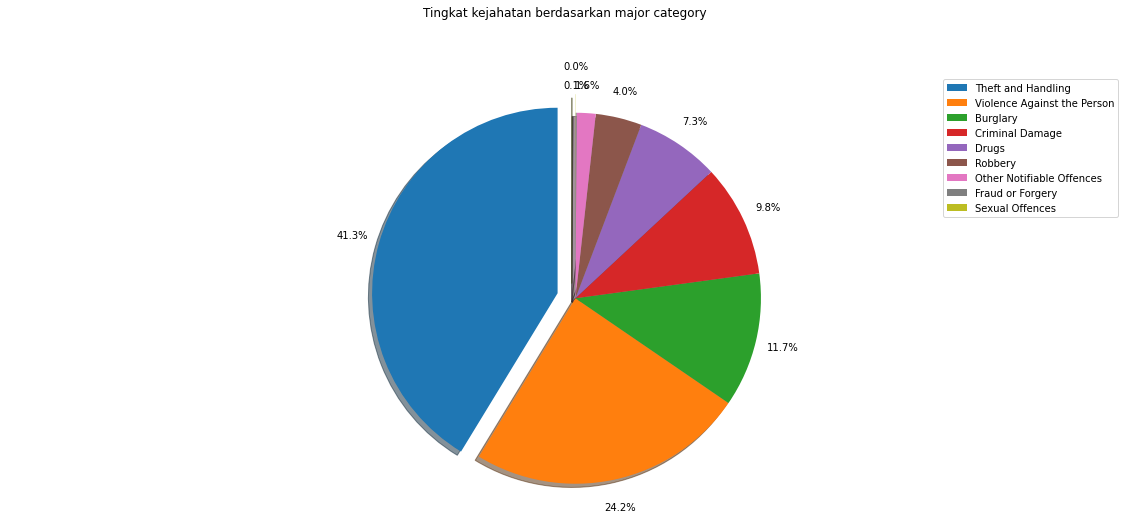

In [85]:
explode_list = [0.1,0,0,0,0,0, 0, 0, 0.1]
crime_major['value'].plot(kind='pie',
                            figsize=(20,8),
                            autopct="%.1f%%",
                            startangle=90,
                            shadow=True,
                            labels=None,
                            pctdistance=1.15,
                            explode=explode_list);

plt.legend(labels=crime_major.index);
plt.title("Tingkat kejahatan berdasarkan major category", y=1.12);
plt.ylabel('');
plt.axis('equal');

Dari tabel dan visualisasi diatas dapat ditarik kesimpulan bahwa kategori **Theft and Handling** memiliki persentase total yang paling besar yakni 41.3% diikuti oleh kategori **Violence Against The Person**. Sedangkan untuk proporsi terkecil terdapat pada kategori **Sexual Offences**.

### 10 Wilayah yang memiliki tingkat kejahatan tertinggi

In [71]:
index = crime_clean[['borough', 'value']].groupby('borough').sum('value').sort_values(by='value', ascending = False).head(10).index

In [20]:
crime_borough = crime_clean[['year','borough', 'value']].groupby(['year', 'borough']).sum('value').unstack()

In [79]:
crime_borough.head(10)

value                                      \
borough Barking and Dagenham Barnet Bexley  Brent Bromley Camden   
year                                                               
2008                   17656  23944  15305  23504   24015  32010   
2009                   17713  23449  14445  24748   21858  31612   
2010                   17130  23416  13166  25512   19572  31804   
2011                   16686  24007  11325  27669   19868  33956   
2012                   15990  23573  11669  26357   19622  31472   
2013                   15759  22510  11552  23759   18945  28435   
2014                   15426  22572  11844  24426   19668  27198   
2015                   16346  24036  11990  24883   20637  29477   
2016                   16741  24684  12840  26693   20164  29183   

                                               ...                          \
borough City of London Croydon Ealing Enfield  ... Merton Newham Redbridge   
year                                           ...                           
2008                 0   29516  28947   21980  ...  13875  29752     20873   
2009                 0   29784  28617   21147  ...  13561  28610     20837   
2010                 0   29373  31360   20808  ...  13595  30728     20652   
2011                69   29830  29537   21041  ...  13548  27978     21994   
2012               157   30189  28832   21069  ...  12856  30067     21424   
2013               110   27444  25917   21574  ...  11595  27577     19793   
2014               115   27357  24978   21700  ...  11596  28005     19590   
2015               151   28089  26247   22076  ...  12273  29217     18897   
2016               178   28712  27127   22485  ...  12755  30090     19502   

                                                                            \
borough Richmond upon Thames Southwark Sutton Tower Hamlets Waltham Forest   
year                                                                         
2008                   11106     33470  12943         23578          24080   
2009                   10618     30623  12240         21959          24761   
2010                   10601     31320  12032         23072          24818   
2011                   10896     30723  11068         24712          23714   
2012                   11168     30737  10948         26784          22647   
2013                   10439     31128  10057         26258          21903   
2014                   10456     28912  10443         25504          20271   
2015                   10413     30260  10598         27493          20969   
2016                   11074     31636  10658         29253          20716   

                                
borough Wandsworth Westminster  
year                            
2008         23330       47846  
2009         23021       48456  
2010         22815       48116  
2011         21384       54243  
2012         24457       59226  
2013         22290       53852  
2014         21364       47564  
2015         22401       47395  
2016         23679       48330  

[9 rows x 33 columns]

In [80]:
crime_borough_top10 = crime_borough['value'].loc[:, index]

In [81]:
crime_borough_top10

borough,Westminster,Lambeth,Southwark,Camden,Newham,Croydon,Ealing,Islington,Tower Hamlets,Brent
year,,,,,,,,,,
2008,47846,31717,33470,32010,29752,29516,28947,26273,23578,23504
2009,48456,31225,30623,31612,28610,29784,28617,25485,21959,24748
2010,48116,31671,31320,31804,30728,29373,31360,24693,23072,25512
2011,54243,33224,30723,33956,27978,29830,29537,24980,24712,27669
2012,59226,33473,30737,31472,30067,30189,28832,26268,26784,26357
2013,53852,31868,31128,28435,27577,27444,25917,23784,26258,23759
2014,47564,31765,28912,27198,28005,27357,24978,24679,25504,24426
2015,47395,33164,30260,29477,29217,28089,26247,27032,27493,24883
2016,48330,34071,31636,29183,30090,28712,27127,27092,29253,26693


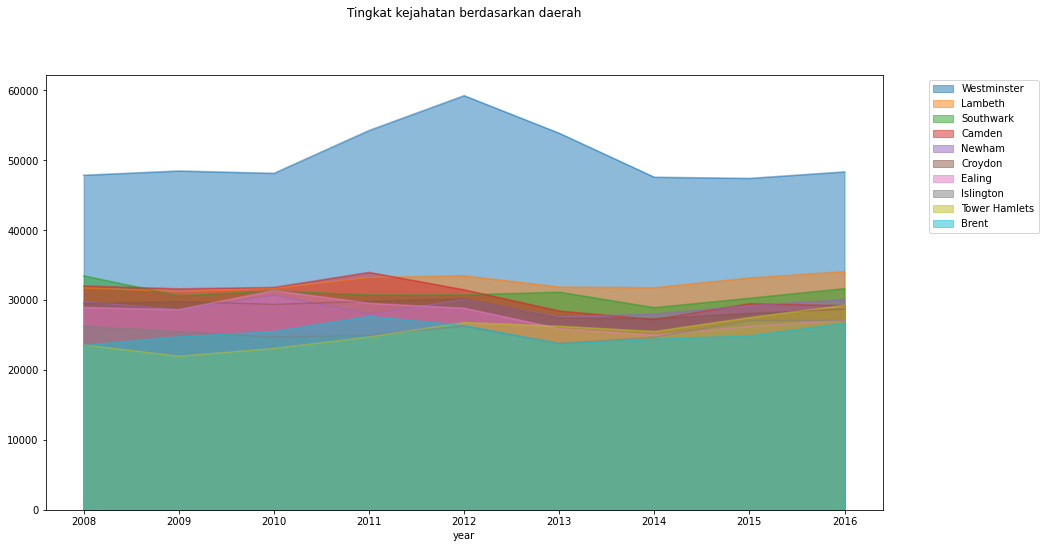

In [86]:
crime_borough_top10.plot(kind='area',
             stacked=False,
             figsize=(15, 8));
plt.legend(bbox_to_anchor = (1.05, 1))
plt.title("Tingkat kejahatan berdasarkan daerah", y=1.12);

Dari tabel dan visualisasi diatas, bahwa wilayah yang memiliki total kejahatan paling tinggi adalah wilayah **Westminster**, **Lambeth**, **Southwark**, **Camden**, **Newham**, **Croydon**, **Ealing**, **Islington**, **Tower Hamlets** dan **Brent**

### Dari 10 wilayah dengan total kejahatan terbanyak, bagaimana pergerakannya pertahun?

Untuk data 10 wilayah dengan kejahatan terbanyak, kita akan menggunakan kembali data yang ada yakni crime_borough_top10

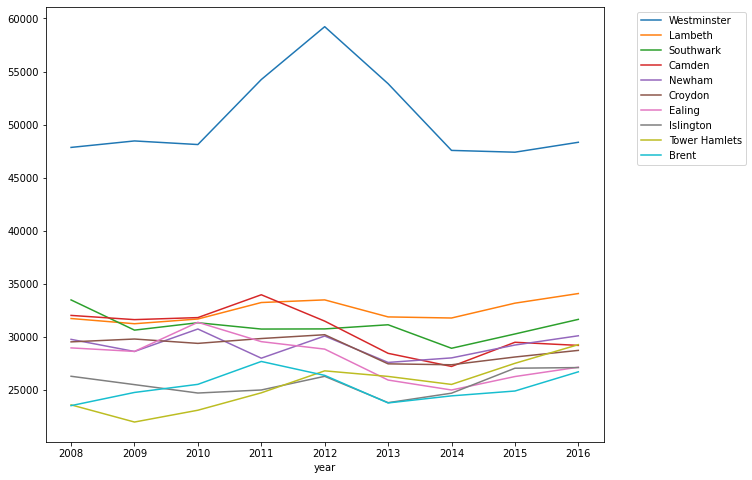

In [91]:
crime_borough_top10.plot(figsize=(10, 8));
plt.legend(bbox_to_anchor = (1.05, 1));

Dari plot diatas, dapat kita lihat bahwa wilayah Westimnster memiliki pergerakan yang cukup signifikan dibandingkan wilayah-wilayah lainnya. pada tahun 2010 hingga 2012, tingkat kejahatan terus menerus meningkat hingga dapat turun kembali pada tahun 2012 dan pada tahun 2014 kembali landai.

### Dari 10 wilayah dengan total kejahatan terbanyak,  bagaimana distribusinya?

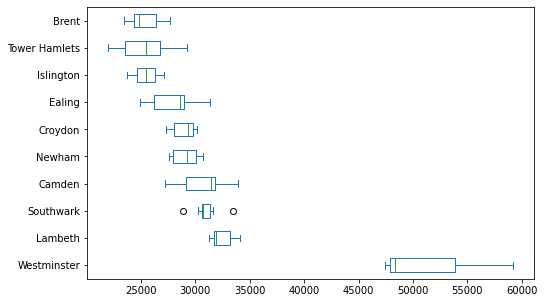

In [101]:
scatter_top10 = crime_borough_top10.plot(kind='box', vert=False,figsize=(8, 5))

Insights : 
- pada scatter plot wilayah **Tower Hamlets**, **Islington** menunjukkan data cukup berdistribusi normal. Sedangkan data yang lainnya menunjukkan kurang terdistribusi normal.
- pada wilayah Southwark tingkat pelaporan kejahatannya terdapat kondisi dimana ada nilai yang tidak biasa dari data-data sebelumnya (ada outlier), terlihat bahwa terdapat peningkatan pelaporan kejahatan yang sangat tinggi dari persebaranya begitupun terdapat juga keadaan dimana ada konidisi pelaporan kejahatan turun drastis 

## Conclusion

- jumlah laporan kejahatan perbulannya berdistribusi pada titik 0 - 62 laporan
- jumlah 3 laporan kejahatan terbanyak terdapat pada kategori Other Theft, Theft From Motor Vehicle dan Burglary in a Dwelling
- bulan tidak mempengaruhi nilai value
- kategori Theft and Handling memiliki persentase total yang paling besar yakni 41.3% diikuti oleh kategori Violence Against The Person. Sedangkan untuk proporsi terkecil terdapat pada kategori Sexual Offences.
- wilayah yang memiliki total kejahatan paling tinggi adalah wilayah Westminster, Lambeth, Southwark, Camden, Newham, Croydon, Ealing, Islington, Tower Hamlets dan Brent
- wilayah Westimnster memiliki pergerakan yang cukup signifikan dibandingkan wilayah-wilayah lainnya. pada tahun 2010 hingga 2012, tingkat kejahatan terus menerus meningkat hingga dapat turun kembali pada tahun 2012 dan pada tahun 2014 kembali landai
- pada scatter plot wilayah **Tower Hamlets**, **Islington** menunjukkan data cukup berdistribusi normal. Sedangkan data yang lainnya menunjukkan kurang terdistribusi normal.
- pada wilayah Southwark tingkat pelaporan kejahatannya terdapat kondisi dimana ada nilai yang tidak biasa dari data-data sebelumnya (ada outlier), terlihat bahwa terdapat peningkatan pelaporan kejahatan yang sangat tinggi dari persebaranya begitupun terdapat juga keadaan dimana ada konidisi pelaporan kejahatan turun drastis 